# Turn image classifier into a generative model

Given a pre-trained image classification model, can we reconstruct the images corresponding to each class? Naively, one could achieve this by inverting the usual training process: instead of tuning the model weights given a fixed input image, we'll fix the model weights and tune the input image trying to maximize probability of one of the classes. Let's see how this works for the MNIST dataset.

In [1]:
import numpy as np
import torch
from torchvision import transforms, datasets
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from train_mnist import Net

## Load data and model

Load MNIST dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset = datasets.MNIST('../data', train=False, download=True,
                       transform=transform)

train_loader = torch.utils.data.DataLoader(dataset)

l1 = [x[0] for x in train_loader]
data_norm = torch.concat(l1)

Load a model pre-trained with a [script from PyTorch examples](https://github.com/pytorch/examples/blob/7ed7ac7b01add7ca29d45f25700e73a4b517ccea/mnist/main.py)

In [3]:
pretrained = Net()
pretrained.load_state_dict(torch.load("mnist_cnn.pt"))

<All keys matched successfully>

Apply the model on some examples from the loaded data 

/opt/anaconda3/envs/p39/lib/python3.9/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor(4) tensor(4)


<AxesSubplot:>

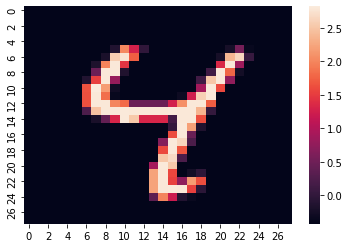

In [4]:
i = 6
t1 = data_norm[i].float()
res = torch.exp(pretrained(data_norm[i].unsqueeze(0)))
print(torch.argmax(res), dataset.train_labels[i])
sns.heatmap(data_norm[i][0])

## Generate initial conditions

In [5]:
def get_random_input(inp_size, max_freq=5):
    """ 
    Generate random smooth input by combining random harmonics
    """
    inp = sum([get_harmonic(Tx, Ty, inp_size) for Tx in range(max_freq) for Ty in range(max_freq)])
    return (inp - inp.min()) / (inp.max() - inp.min())


def get_harmonic(Tx, Ty, inp_size):
    """ 
    Generate a random harmonic
    """
    lx = torch.linspace(0, np.pi * Tx, inp_size).unsqueeze(0) + 2 * np.pi * np.random.rand()
    ly = torch.linspace(0, np.pi * Ty, inp_size).unsqueeze(1)  + 2 * np.pi * np.random.rand()
    return np.random.rand() * torch.sin(lx) * torch.sin(ly)

How does a typical input look like?

<AxesSubplot:>

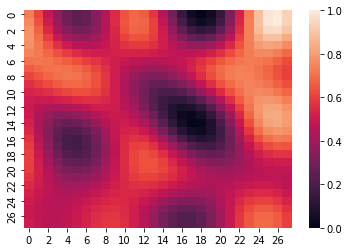

In [6]:
sns.heatmap(get_random_input(28))

## Generate images

Define the model

In [8]:
class NewNet(torch.nn.Module):
    def __init__(self, inp_size=28, inp=None):
        super(NewNet, self).__init__()
        if inp is not None:
            self.inp = torch.nn.Parameter(inp)
        else:
            self.inp = torch.nn.Parameter(0.1 * get_random_input(inp_size).unsqueeze(0).unsqueeze(0))
        self.pretrained = pretrained
        for param in self.pretrained.parameters():
            param.requires_grad = False
        self.pretrained.dropout1 = torch.nn.Identity()
        self.pretrained.dropout2 = torch.nn.Identity()
        
    def forward(self):
        x = torch.exp(self.pretrained(self.inp))
        return x

In [19]:
import joblib

def generate(clas_idx, inp=None, n_steps=100000, lr=0.1):

    target = torch.zeros(10).unsqueeze(0)
    target[0, clas_idx] = 1

    model = NewNet(inp=inp)
    optimizer = torch.optim.SGD([model.inp], lr=lr)

    running_loss = 0
    for i in range(n_steps):
        optimizer.zero_grad()
        outs = model()
        inp_for_reg = 2 * model.inp - 1
        reg = torch.nn.functional.relu(- model.inp).sum() + torch.nn.functional.relu(model.inp - 1).sum()
        kl_loss = ((outs - target) ** 2).sum() + reg
        loss = kl_loss
        loss.backward()
        optimizer.step()
        if i % 1000 == 0:
            print(loss.item())
    return model.inp.detach()

def show_image_grid(rand_inps, nrows=2, ncols=2, title=None):
    
    figure, axes = plt.subplots(nrows, ncols, figsize=(6, 6))
    for i, im in enumerate(rand_inps):
        sns.heatmap(im[0, 0], ax=axes[i // ncols][i % ncols], square=True)
    if title:
        figure.suptitle(title)
    plt.show()

Generating digit 0


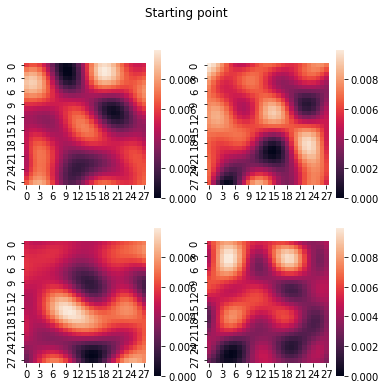

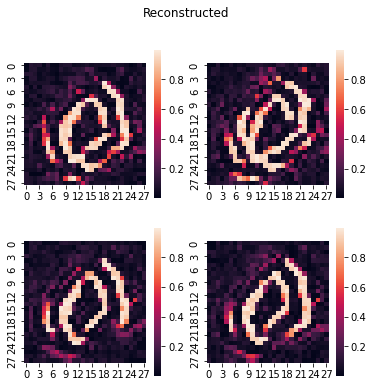

Generating digit 1


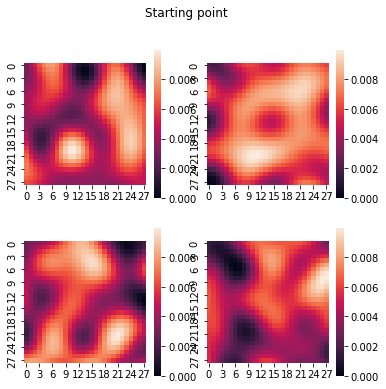

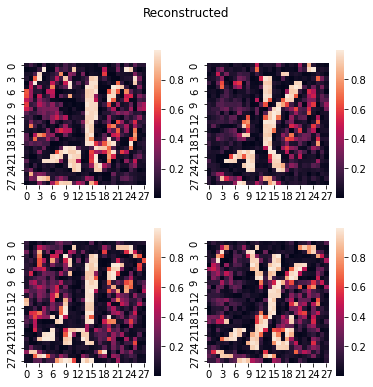

Generating digit 2


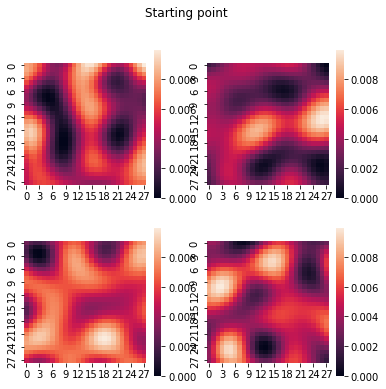

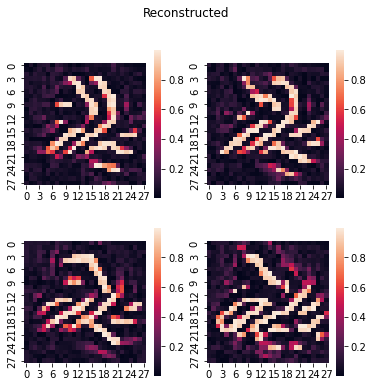

Generating digit 3


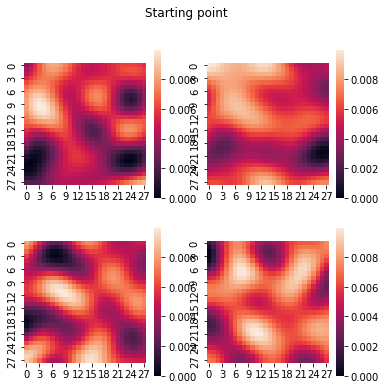

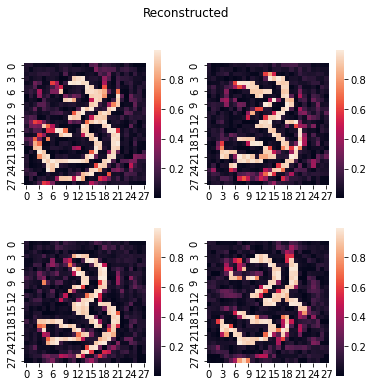

Generating digit 4


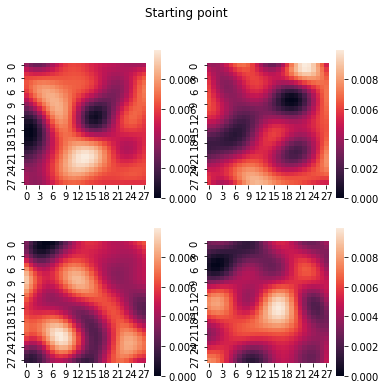

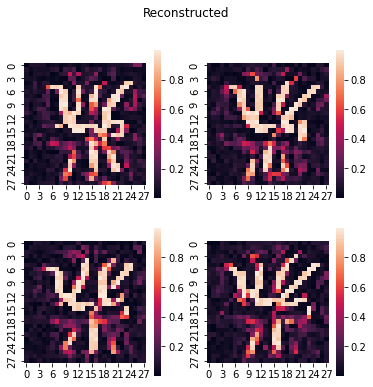

Generating digit 5


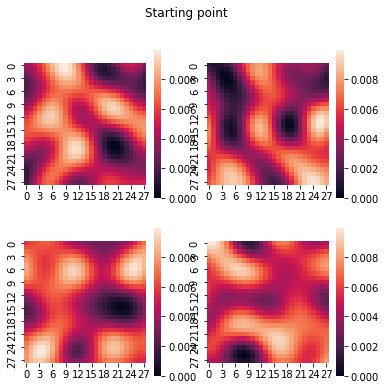

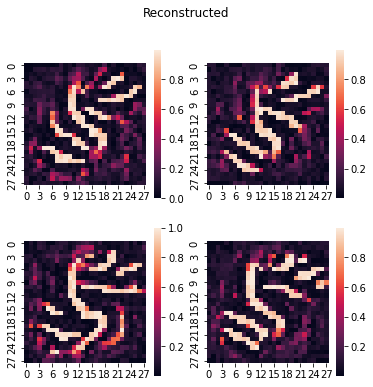

Generating digit 6


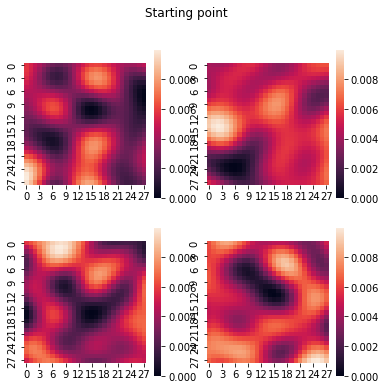

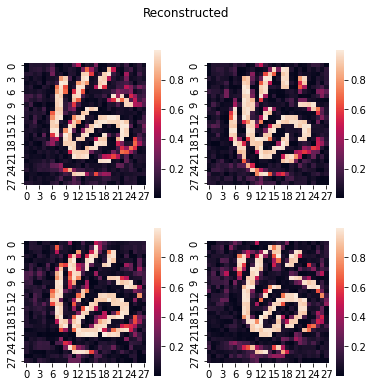

Generating digit 7


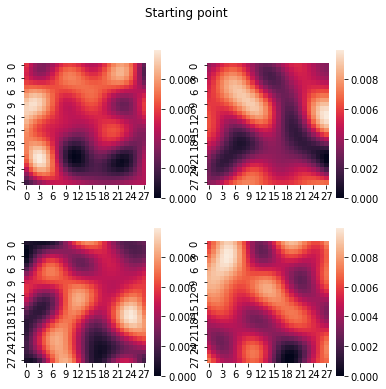

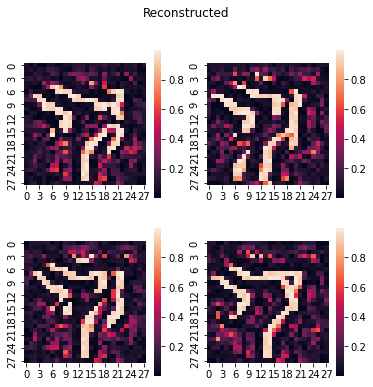

Generating digit 8


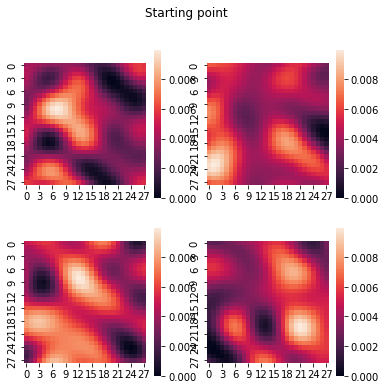

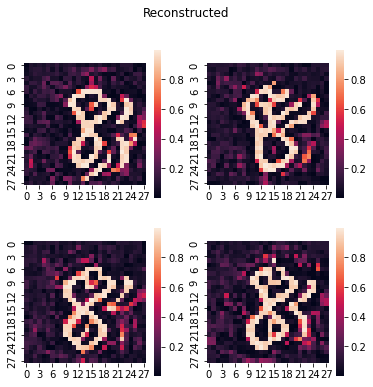

Generating digit 9


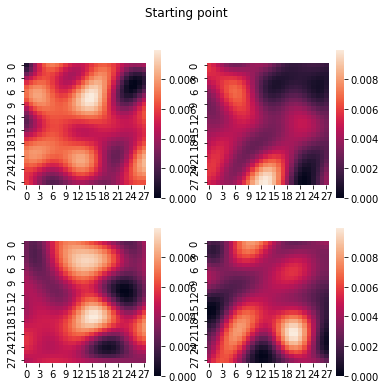

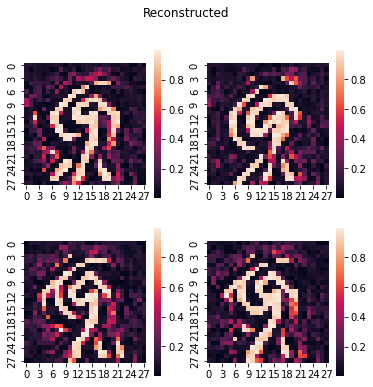

In [23]:
for digit in range(10):
    print(f"Generating digit {digit}")
    rand_inps = [0.01 * get_random_input(28).unsqueeze(0).unsqueeze(0) for _ in range(4)]
    show_image_grid(rand_inps, title="Starting point")
    res = joblib.Parallel(n_jobs=4)(joblib.delayed(generate)(digit, n_steps=100000, inp=rand_inps[i]) for i in range(4))
    show_image_grid([r for r in res], title="Reconstructed")

Generating digit 0


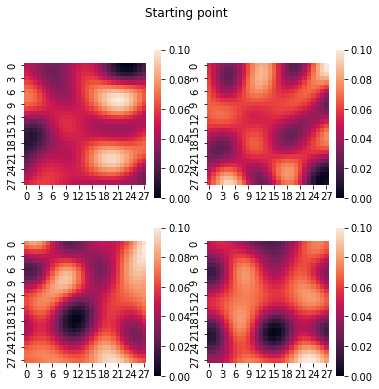

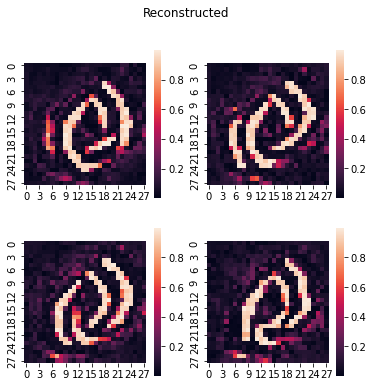

Generating digit 1


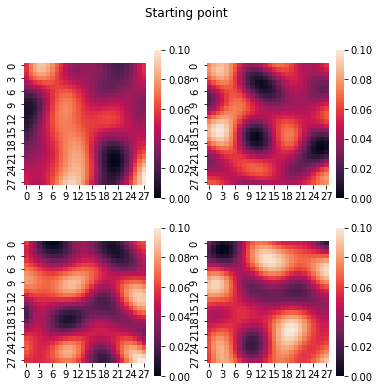

0.9247024059295654
0.9254761338233948
0.9239487051963806
0.9223902821540833
0.9161064028739929
0.787588357925415
0.05216961354017258
0.026866642758250237
0.016711488366127014
0.011128464713692665
0.009990137070417404
0.007593829650431871
0.007063544820994139
0.006094617303460836
0.006111375521868467
0.006310830824077129
0.006141871213912964
0.005305960774421692
0.005210516043007374
0.005286212544888258
0.005284145474433899
0.00456239515915513
0.004500566981732845
0.004681549966335297
0.004496309440582991
0.003911957610398531
0.00391731783747673
0.004647543653845787
0.0043146638199687
0.0037825312465429306
0.003892787266522646
0.003614489920437336
0.0037082454655319452
0.0036914823576807976
0.00363146816380322
0.00306248152628541
0.0037426527123898268
0.004051747731864452
0.0036947515327483416
0.0036122945602983236
0.0031484446953982115
0.0033473887015134096
0.0032166570890694857
0.002807635348290205
0.0032158545218408108
0.0032872380688786507
0.0029854681342840195
0.0029455251060426235

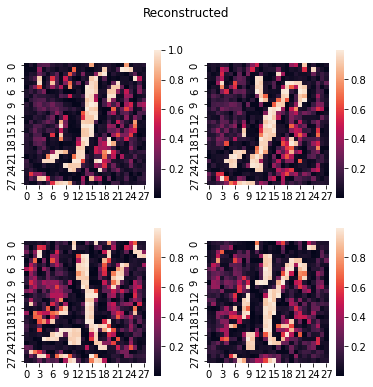

Generating digit 2


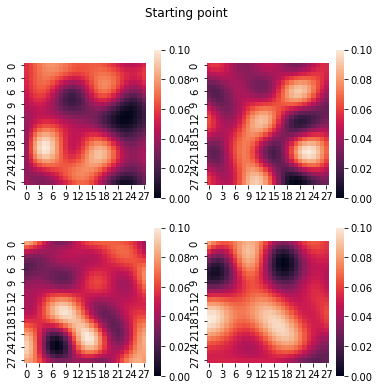

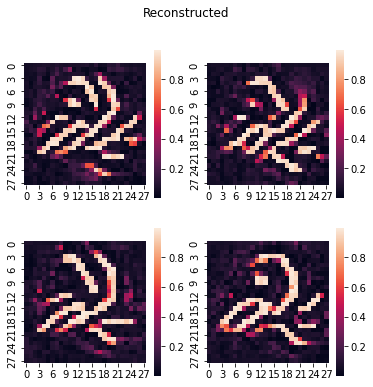

Generating digit 3


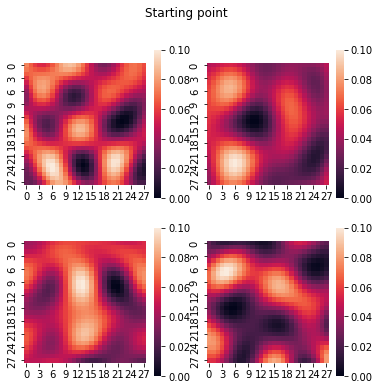

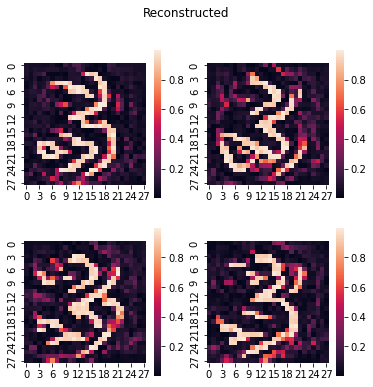

Generating digit 4


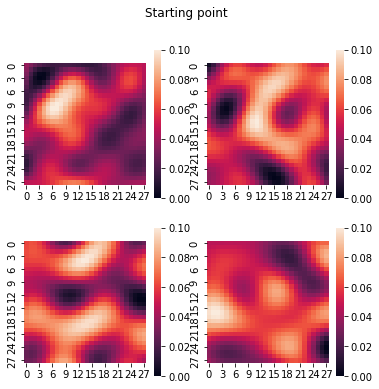

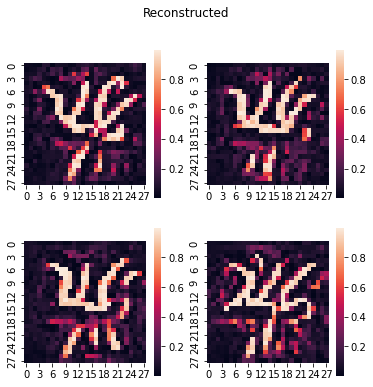

Generating digit 5


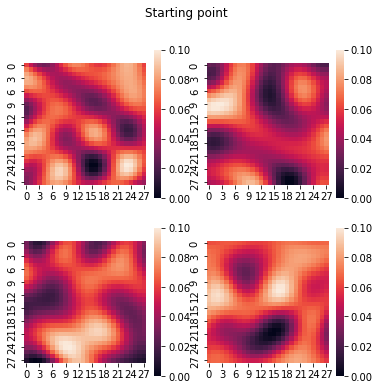

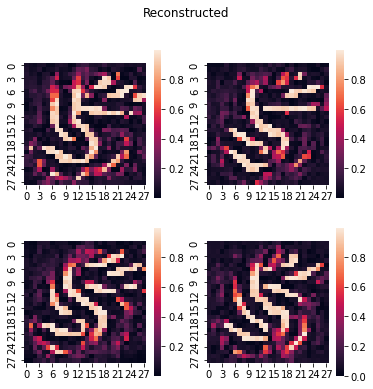

Generating digit 6


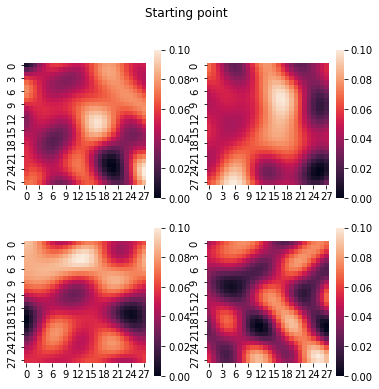

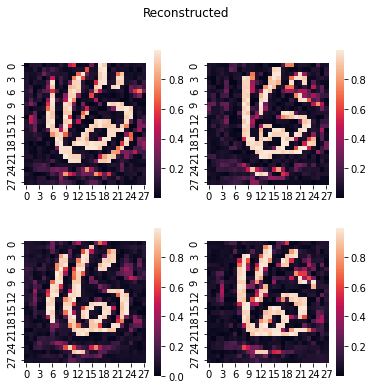

Generating digit 7


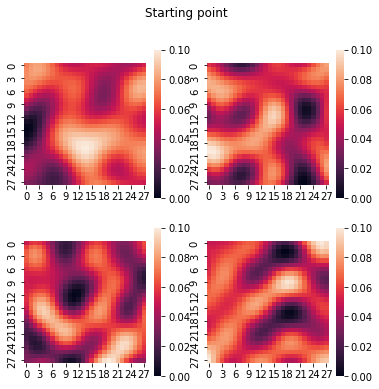

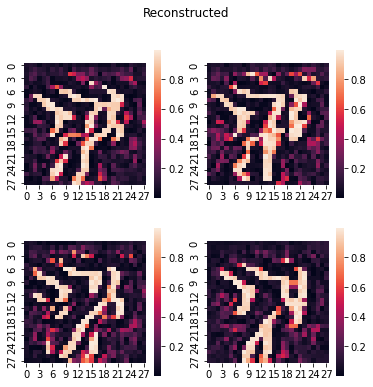

Generating digit 8


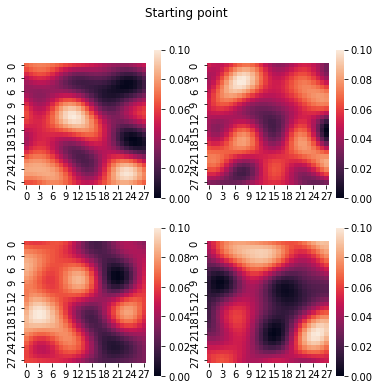

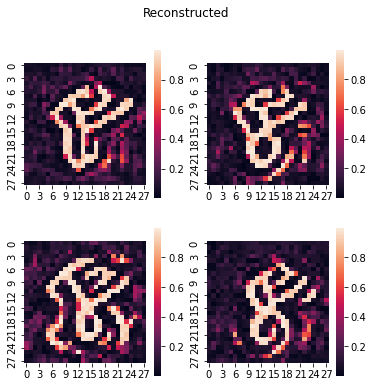

Generating digit 9


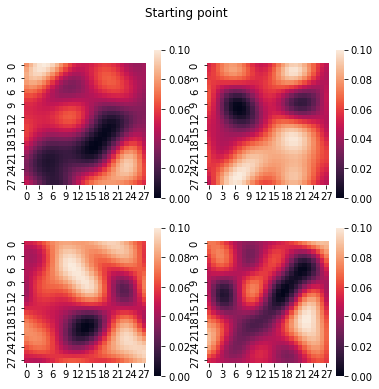

0.002238782122731209
0.0022570688743144274
0.002451525302603841
0.0020673787221312523
0.0024895011447370052
0.002094009891152382
0.0023758751340210438
0.0024414374493062496
0.0022225358989089727
0.0020647174678742886
0.002085441257804632
0.0023901835083961487
0.002202573698014021
0.002347353845834732
0.0018874318338930607
0.0022887305822223425
0.00245938403531909
0.002221146132797003
0.002096816897392273
0.0026328188832849264
0.0019460644107311964
0.0020551325287669897
0.0020826528780162334
0.00220802566036582
0.0023484143894165754
0.0019964466337114573
0.0023603776935487986
0.001976973609998822
0.002231696853414178
0.0018115926068276167
0.002145018894225359
0.9229838848114014
0.9241995215415955
0.9232245087623596
0.9227098226547241
0.9221157431602478
0.9218016862869263
0.9216707944869995
0.921363353729248
0.9212198257446289
0.9207329750061035
0.9204285144805908
0.9202028512954712
0.9197030067443848
0.9187021255493164
0.9133579730987549
0.8631406426429749
0.41005709767341614
0.03459214

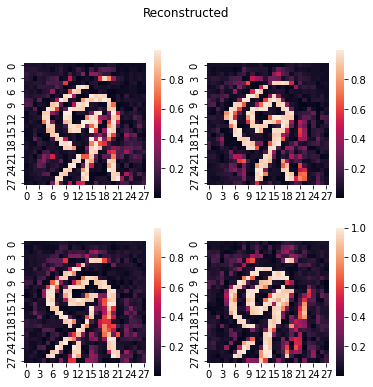

0.004294291138648987
0.00395559798926115
0.0036135325208306313
0.0036625585053116083
0.003488688264042139
0.003225830150768161
0.0033334726467728615
0.0031785015016794205
0.0035552745684981346
0.0037902332842350006
0.003622382180765271
0.003275288036093116
0.0029476392082870007
0.002735028974711895
0.003284863196313381
0.0028353817760944366
0.0035224207676947117
0.0035290252417325974
0.0034413086250424385
0.003038985887542367
0.0034805971663445234
0.0038072688039392233
0.003113984828814864
0.0029954672791063786
0.0030134140979498625
0.002941609127447009
0.002453820314258337
0.002720065414905548
0.002247680677101016
0.0028044546488672495
0.00317959813401103
0.002626941306516528
0.0030344068072736263
0.0023171575739979744
0.003042834345251322
0.0022776955738663673
0.0023880924563854933
0.00264986464753747
0.0024414858780801296
0.0028347382321953773
0.0030929134227335453
0.0023766427766531706
0.002500646049156785
0.0025123991072177887
0.0024537730496376753
0.002030298113822937
0.002621310

In [24]:
for digit in range(10):
    print(f"Generating digit {digit}")
    rand_inps = [0.1 * get_random_input(28).unsqueeze(0).unsqueeze(0) for _ in range(4)]
    show_image_grid(rand_inps, title="Starting point")
    res = joblib.Parallel(n_jobs=4)(joblib.delayed(generate)(digit, n_steps=100000, inp=rand_inps[i]) for i in range(4))
    show_image_grid([r for r in res], title="Reconstructed")

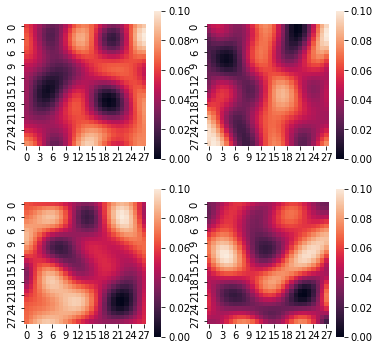

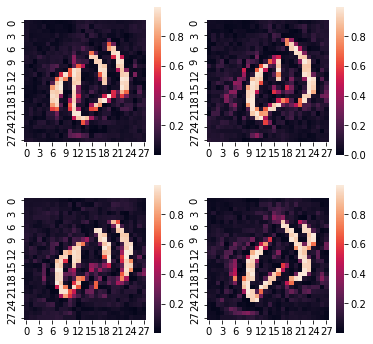

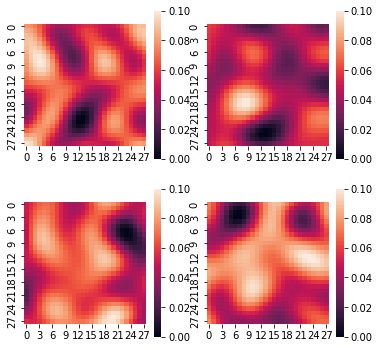

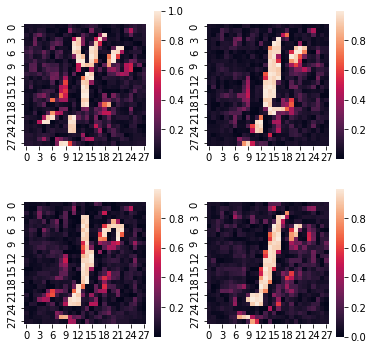

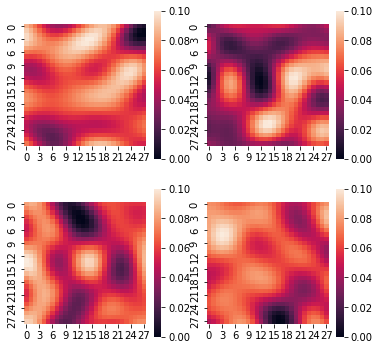

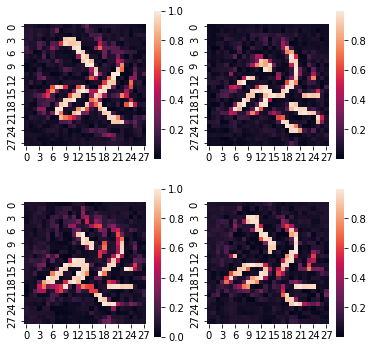

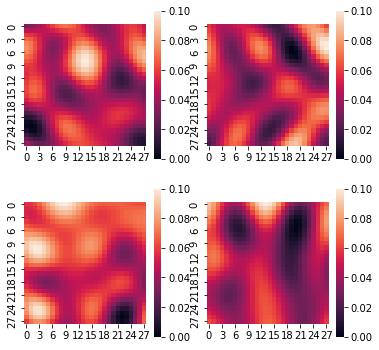

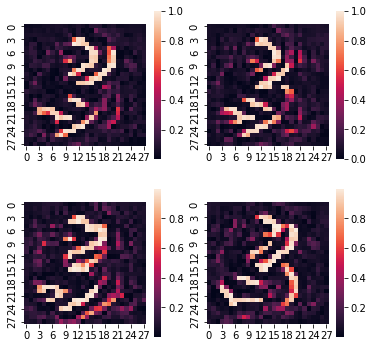

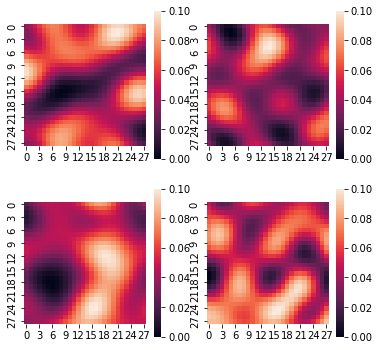

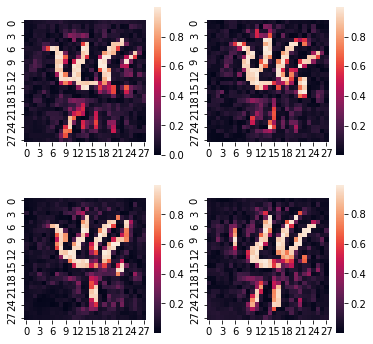

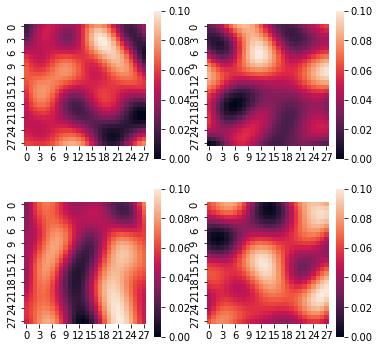

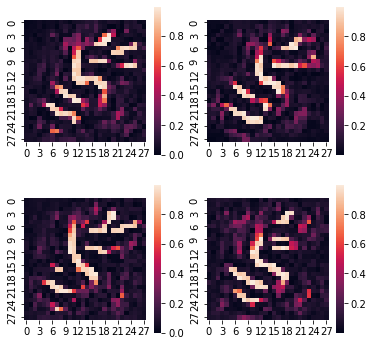

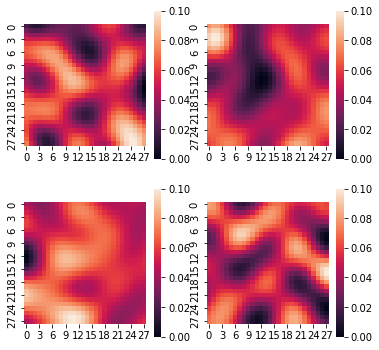

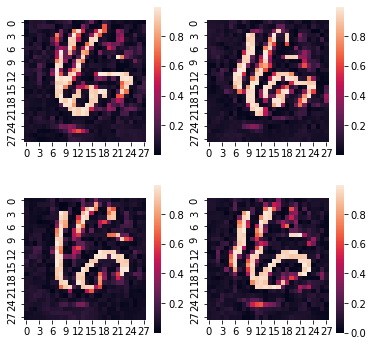

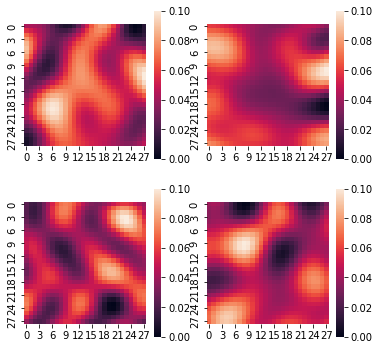

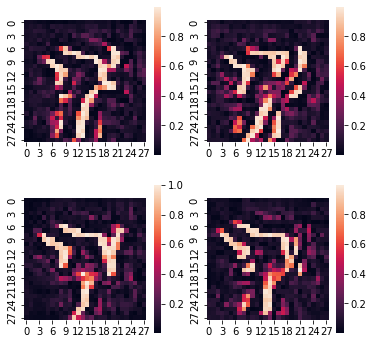

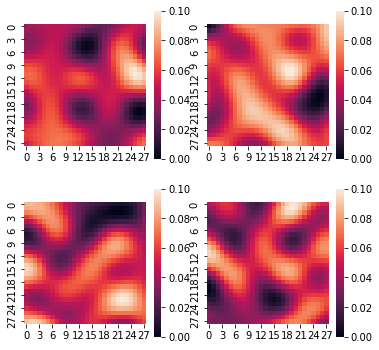

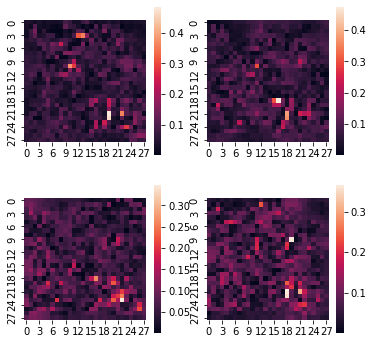

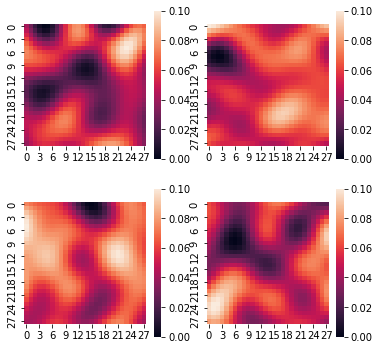

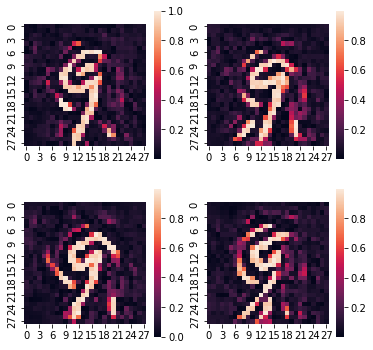

In [10]:
for digit in range(10):
    rand_inps = [0.1 * get_random_input(28).unsqueeze(0).unsqueeze(0) for _ in range(4)]
    show_image_grid(rand_inps)
    res = joblib.Parallel(n_jobs=4)(joblib.delayed(generate)(digit, n_steps=10000, inp=rand_inps[i]) for i in range(4))
    show_image_grid([r for r in res])